# Анализ и прогнозирование снижения покупательской активности для интернет-магазина «В один клик»

Интернет-магазин «В один клик» сталкивается с проблемой снижения активности постоянных покупателей. Привлечение новых клиентов становится менее эффективным, поэтому основной задачей становится удержание уже существующих клиентов. 

В рамках проекта нужно разработать модель, которая будет прогнозировать вероятность снижения покупательской активности, а также произвести сегментацию клиентов.

## Цель проекта

- Разработать модель, предсказывающую вероятность снижения покупательской активности постоянных клиентов;
- Провести сегментацию клиентов на основе результатов моделирования и других признаков;
- Проанализировать выделенные сегменты и предложить рекомендации по увеличению покупательской активности;

## Ход исследования

1. Загрузка и первичный обзор данных
2. Предобработка данных
3. Исследовательский анализ данных (EDA)
    - Анализ каждой таблицы
    - Отбор клиентов с активностью не менее трёх месяцев
    - Формулировка выводов
4. Объединение таблиц
    - Объединение market_file, market_money, market_time
    - Создание отдельных столбцов для каждого периода
5. Корреляционный анализ
    - Анализ корреляций количественных признаков
    - Проверка и устранение мультиколлинеарности
6. Построение пайплайнов и обучение моделей
    - Раздельная обработка количественных и категориальных признаков
    - Применение разных кодировщиков и скейлеров
    - Обучение моделей: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC
    - Подбор гиперпараметров
    - Выбор метрики и лучшей модели
7. Анализ важности признаков
    - Оценка важности признаков для лучшей модели
    - Визуализация с помощью SHAP
    - Формулировка выводов
8. Сегментация покупателей
    - Сегментация на основе моделирования и прибыльности
    - Анализ выбранного сегмента
    - Предложения по увеличению активности
    - Выводы по сегментам
9. Общий вывод

## Загрузка данных

In [148]:
#Установка библиотек
!pip install -q shap scikit-learn==1.1.3 matplotlib==3.5.2

# Стандартные библиотеки
import warnings

# Сторонние библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

from scipy import stats

# Scikit-learn: базовые инструменты
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Scikit-learn: препроцессинг
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
)

# Scikit-learn: модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Scikit-learn: метрики
from sklearn.metrics import f1_score, classification_report, roc_auc_score


RANDOM_STATE = 42

In [149]:
def read_csv_if_exists(path, var_name='DataFrame'):
    if os.path.exists(path):
        print(f"Загрузка {var_name} из: {path}")
        return pd.read_csv(path)
    else:
        print(f"Файл не найден: {path}")
        return None

market_file = read_csv_if_exists('/datasets/market_file.csv', 'market_file')
market_money = read_csv_if_exists('/datasets/market_money.csv', 'market_money')
market_time = read_csv_if_exists('/datasets/market_time.csv', 'market_time')
money = read_csv_if_exists('/datasets/money.csv', 'money')

Загрузка market_file из: /datasets/market_file.csv
Загрузка market_money из: /datasets/market_money.csv
Загрузка market_time из: /datasets/market_time.csv
Загрузка money из: /datasets/money.csv


In [150]:
print(market_file.info())
print(f'\n Кол-во явных дубликатов в таблице "market_file:" {market_file.duplicated().sum()}')
market_file.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [151]:
print(market_money.info())
print(f'\n Кол-во явных дубликатов в таблице "market_money:" {market_money.duplicated().sum()}')
market_money.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None

 Кол-во явных дубликатов в таблице "market_money:" 0


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [152]:
print(market_time.info())
print(f'\n Кол-во явных дубликатов в таблице "market_time:" {market_time.duplicated().sum()}')
market_time.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None

 Кол-во явных дубликатов в таблице "market_time:" 0


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [153]:
print(money.info())
print(f'\n Кол-во явных дубликатов в таблице "money:" {money.duplicated().sum()}')
money.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348;0 to 216647;3
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id;Прибыль  1284 non-null   float64
dtypes: float64(1)
memory usage: 20.3+ KB
None

 Кол-во явных дубликатов в таблице "money:" 1209


,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0


**Вывод:** 
`market_file:` Содержит 1300 уникальных клиентов и 13 признаков, полностью соответствует описанию. Пропусков нет, данные чистые.

`market_money:` Содержит 3900 строк (по 3 периода на каждого клиента), пропусков нет. Формат данных корректный.

`market_time:` Содержит 2600 строк (по 2 периода на каждого клиента), пропусков нет. Формат данных корректный. *Требуется проверить корректность периодов: есть опечатка: `предыдцщий_месяц`.*

`money:` Содержит 1300 строк, но 16 пропусков в столбце прибыли. Также есть проблема с разделителем: id и прибыль объединены в один столбец через точку с запятой. 
*Треубется разделить на два столбца и обработать пропуски. Привести `Прибыль` к типу `float`.*

Явные дубликаты отсутствуют.

## Предобработка данных

### Исправление структуры и типа данных таблицы `money`

In [154]:
money = pd.read_csv('/datasets/money.csv', sep=';', names=['id', 'Прибыль'], header=0)

money['id'] = money['id'].astype(int)
money['Прибыль'] = money['Прибыль'].str.replace(',', '.').astype(float)

print(money.info())
print('\n Кол-во пропусков: \n', money.isna().sum())
money.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None

 Кол-во пропусков: 
 id         0
Прибыль    0
dtype: int64


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Проверка поля `id` на уникальность

In [155]:
print('Уникальных id в market_file:', market_file['id'].nunique())
print('Всего строк в market_file:', len(market_file))
print('Уникальных id в money:', money['id'].nunique())
print('Всего строк в money:', len(money))

Уникальных id в market_file: 1300
Всего строк в market_file: 1300
Уникальных id в money: 1300
Всего строк в money: 1300


**Вывод:** Необходимо проверить поле `id` на уникальность в таблицах `market_file`, `money`, поскольку каждая строка - это отдельный пользователь. Нужно убедиться, что нет дубликатов. В таблицах `market_money` и `market_time` поля могут повторяться, потому что у одного пользователя может быть несколько записей.

Исходя из проверки можно сделать вывод, что с полем `id` все в порядке, дубликатов нет.

### Приведение к типу `category`

In [156]:
# market_time
market_time['Период'] = market_time['Период'].astype('category')

# market_money
market_money['Период'] = market_money['Период'].astype('category')

# market_file
market_file['Покупательская активность'] = market_file['Покупательская активность'].astype('category')
market_file['Тип сервиса'] = market_file['Тип сервиса'].astype('category')
market_file['Разрешить сообщать'] = market_file['Разрешить сообщать'].astype('category')
market_file['Популярная_категория'] = market_file['Популярная_категория'].astype('category')

In [157]:
print(market_time.info())
print(market_money.info())
print(market_file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      2600 non-null   int64   
 1   Период  2600 non-null   category
 2   минут   2600 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 43.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       3900 non-null   int64   
 1   Период   3900 non-null   category
 2   Выручка  3900 non-null   float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 65.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                             

### Поиск и обработка неявных дубликатов

In [158]:
dfs = [
    ('market_file', market_file),
    ('market_time', market_time),
    ('market_money', market_money)
]

# Поиск категориальных значений и вывод их уникальных значений
for name, df in dfs:
    print(f'\nКатегориальные столбцы в {name}:')
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        print(f'    {col}:')
        print(f'        {df[col].unique()}')


Категориальные столбцы в market_file:
    Покупательская активность:
        ['Снизилась', 'Прежний уровень']
Categories (2, object): ['Снизилась', 'Прежний уровень']
    Тип сервиса:
        ['премиум', 'стандартт', 'стандарт']
Categories (3, object): ['премиум', 'стандартт', 'стандарт']
    Разрешить сообщать:
        ['да', 'нет']
Categories (2, object): ['да', 'нет']
    Популярная_категория:
        ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']
Categories (6, object): ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']

Категориальные столбцы в market_time:
    Период:
        ['текущий_месяц', 'предыдцщий_месяц']
Categories (2, object): ['текущий_месяц', 'предыдцщий_месяц']

Категориальные столбцы в market_money:
    Период:
        ['препредыдущий_месяц', 'тек

In [159]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_file['Популярная_категория'] = market_file['Популярная_категория'].replace('Косметика и аксесуары', 'Косметика и аксессуары')

print(f'Уникальные значения поля "Тип сервиса после удаления:" {market_file["Тип сервиса"].unique()}')
print(f'Уникальные значения поля "Тип сервиса после удаления:" {market_time["Период"].unique()}')
print(f'Уникальные значения поля "Популярная категория после удаления:" {market_file["Популярная_категория"].unique()}')

Уникальные значения поля "Тип сервиса после удаления:" ['премиум', 'стандарт']
Categories (2, object): ['премиум', 'стандарт']
Уникальные значения поля "Тип сервиса после удаления:" ['текущий_месяц', 'предыдущий_месяц']
Categories (2, object): ['текущий_месяц', 'предыдущий_месяц']
Уникальные значения поля "Популярная категория после удаления:" ['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']
Categories (6, object): ['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары', 'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']


**Вывод:** Были выявлены неявные дубликаты в:
- `market_file` в поле `Тип сервиса`;
- `market_time` в поле `Период`;

Так же найдена опечата в `market_file` в поле `Популярная_категория`: `Косметика и аксесуары`

Дубликаты были успешно удалены.

## Исследовательский анализ данных (EDA)

### Анализ `market_file`

In [160]:
print('Анализ market_file:')
market_file.describe()

Анализ market_file:


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


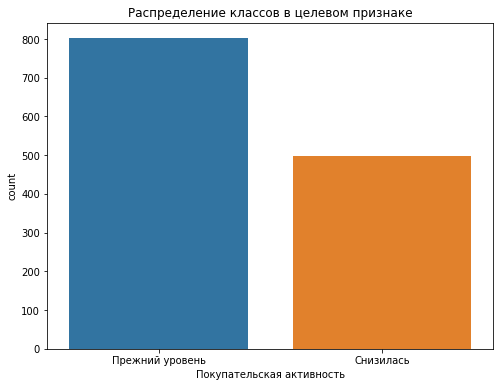

In [161]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Покупательская активность', data=market_file)
plt.title('Распределение классов в целевом признаке')
plt.show()

**Вывод:** 
- `Маркет_актив_6_мес`: В среднем, на каждого покупателя приходится 4.25 маркетинговых коммуникаций в месяц за последние 6 месяцев. Стандартное отклонение составляет примерно 1, что говорит о небольшой вариативности;
- `Маркет_актив_тек_мес`: Среднее кол-во маректиноговых коммуникаций составляет 4.01 в этом месяце, что немного ниже, чем за последние 6.
- `Длительность`: Средняя длительность регистрации пользователя на сайте составляет 602 дня. Что говорит о том, что присутствуют как новые, так и "старые" клиенты;
- `Акционные_покупки`: В среднем около 32% покупок совершаются по акции;
- `Средний_просмотр_категорий_за_визит`: Около 3.27 категорий просматривает покупатель за один визит;
- `Неоплаченные_продукты_штук_квартал`: У покупателей около 2.84 неоплаченных товаров за последние 3 месяца;
- `Ошибка_сервиса`: В среднем, покупатель сталкивается с 4.19 ошибками сервиса. Это довольно высокий показатель, который может негативно влиять на покупательскую активность;
- `Страниц_за_визит`: В среднем, покупатель просматривает около 8.18 страниц за один визит.

Из графиков видно:
- *Несбалансированность классов*: На графике видно, что количество клиентов с "Прежним уровнем" покупательской активности значительно больше, чем количество клиентов, чья активность "Снизилась". Это говорит о несбалансированности классов в целевом признаке.
- *Преобладание "Прежнего уровня"*: Количество клиентов с "Прежним уровнем" составляет около 800, в то время как количество клиентов с "Снизилась" составляет около 500.

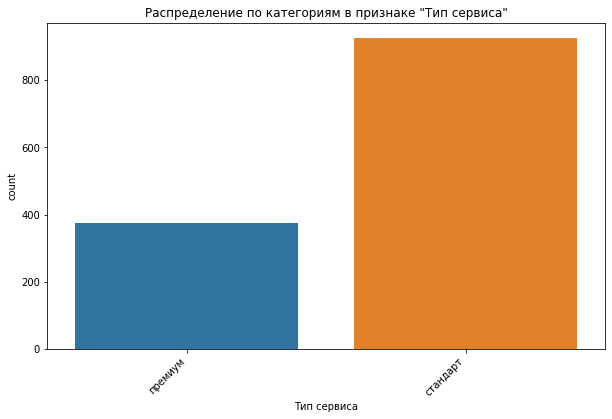

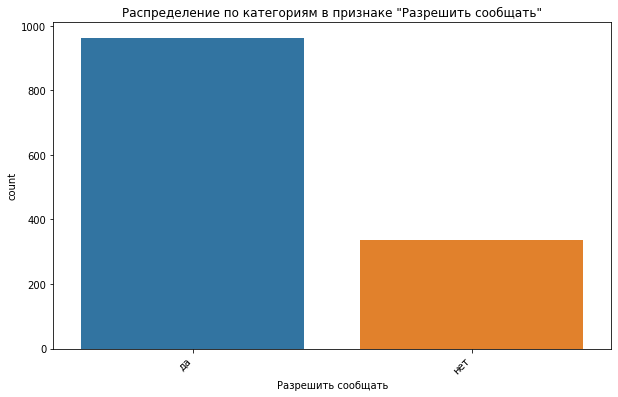

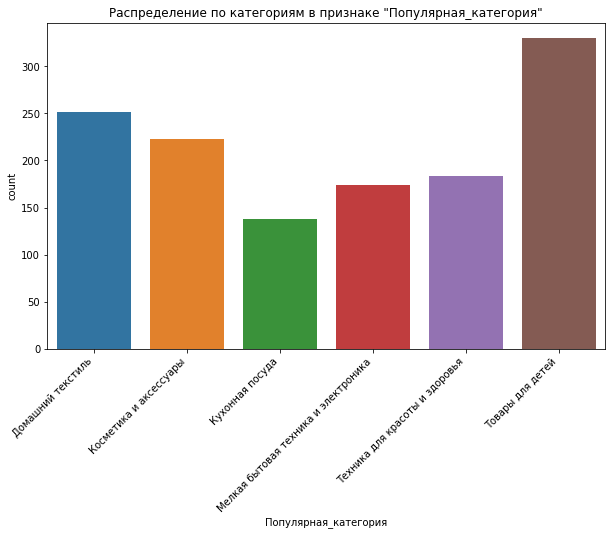

In [162]:
categorical_features = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, data=market_file)
    plt.title(f'Распределение по категориям в признаке "{feature}"')
    plt.xticks(rotation=45, ha='right')
    plt.show()

**Вывод:** Из графиков видно:
- Большинство клиентов пользуются стандартным типом сервиса (около 900), в то время как премиум-сервис используют около 400 клиентов;
- Большинство клиентов (около 950) разрешают присылать им дополнительные предложения о товаре, в то время как около 350 клиентов не дают такого разрешения;
- Самой популярной категорией товаров является "Товары для детей" (около 320), за ней следуют "Домашний текстиль" и "Косметика и аксессуары" (около 250 каждая). Менее популярными являются "Кухонная посуда" и "Техника для красоты и здоровья" (около 180 каждая);

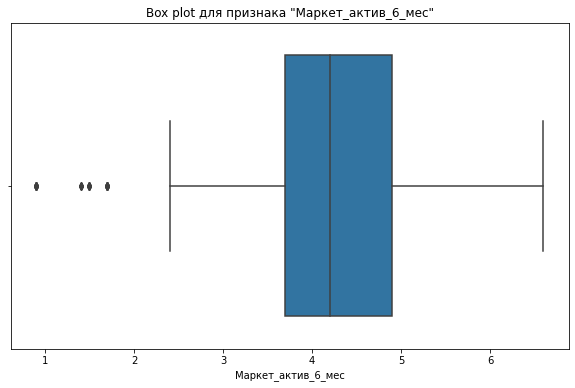

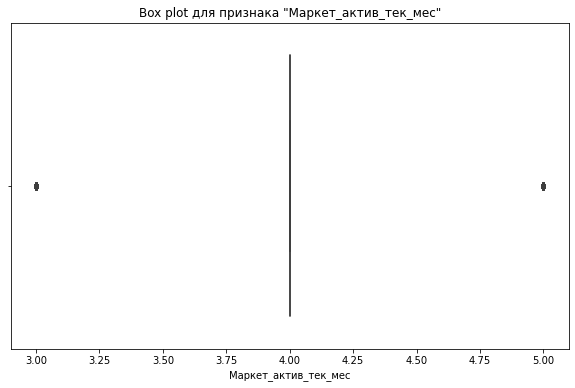

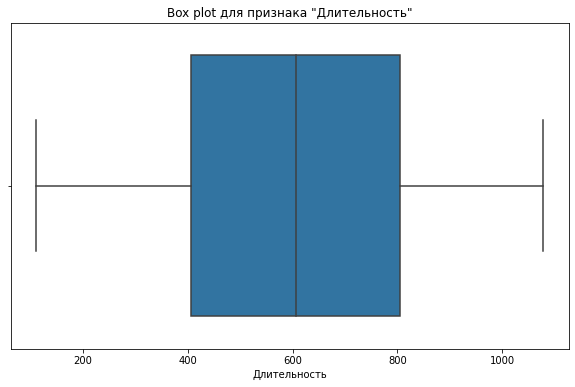

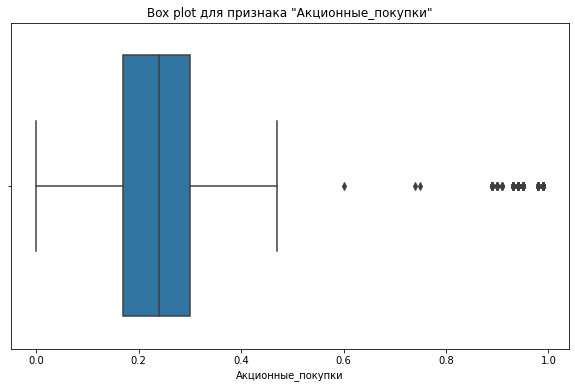

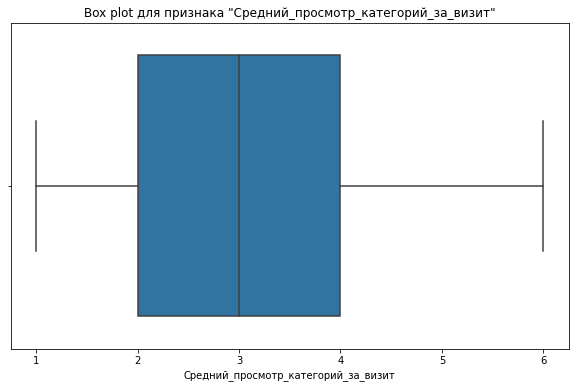

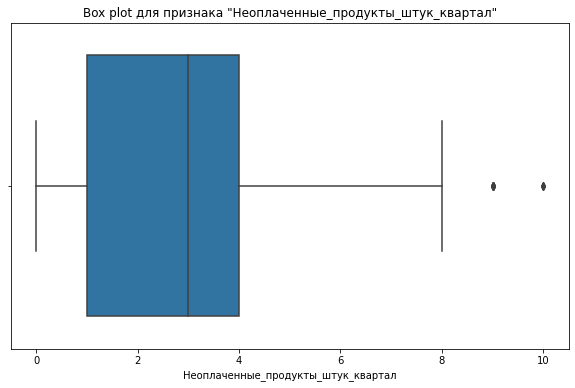

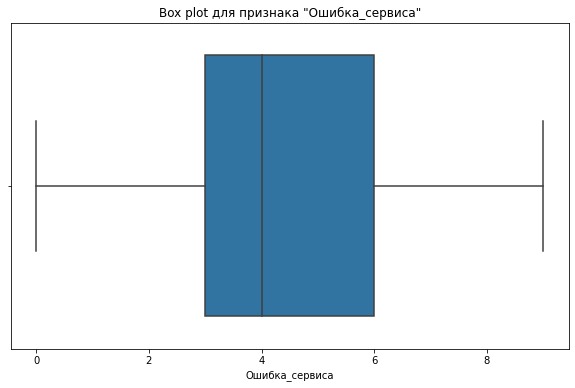

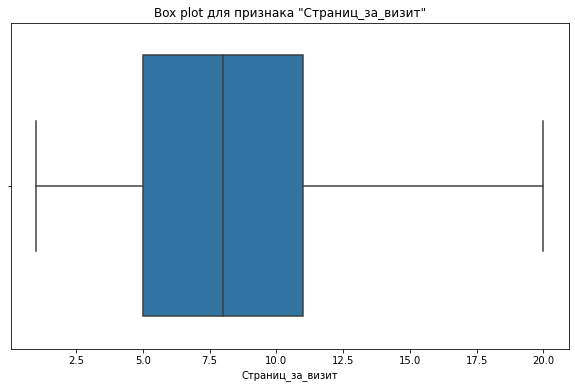

In [163]:
numerical_features = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=market_file[feature])
    plt.title(f'Box plot для признака "{feature}"')
    plt.show()

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично!  Боксплот рядом с гистограммой - это отлично! Гистограмма будет показывать нам распределение количественного признака, а боксплот даст информацию о **возможных выбросах** (пишу **возможных**, потому что нужно анализировать бизнесовый смысл значений показанных как выбросы ... просто так удалять то, что показывает боксплот за пределами 1,5 IQR от границ "ящика" - неверно) и основных статистиках (квартилях) признака.

p.s. Для дискретных признаков "ящики с усами" не нужны, так как эти признаки имеют скорее распределение категориального признака, пусть и представленного в численном виде.

</div>

**Вывод:** Из графиков видно, что присутствуют небольшие выбросы в полях: 
- `Маркет_актив_6_мес`: менее 2;
- `Маркет_актив_тек_мес`: 3 и 5;
- `Акционные_покупки`: более 0.5;
- `Неоплаченные_продукты_штук_квартал`: более 8;

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Почему реальное поведение покупателей вдруг стало выбросами? Потому что ящик с усами нарисовал несколько точек выше/ниже ящика? Так дело не пойдёт: ты реальное поведение живых покупателей приводишь к красивой и неправдоподобно "гладкой" картинке. Как твоя модель в итоге будет работать на реальных данных?
    
</div> 

--- Анализ распределения непрерывных признаков ---


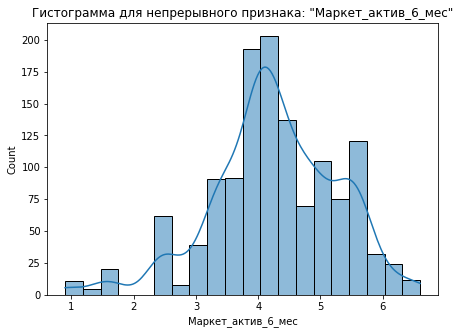

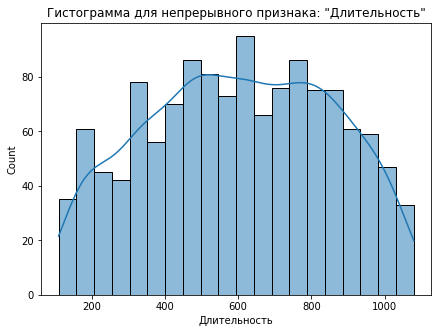

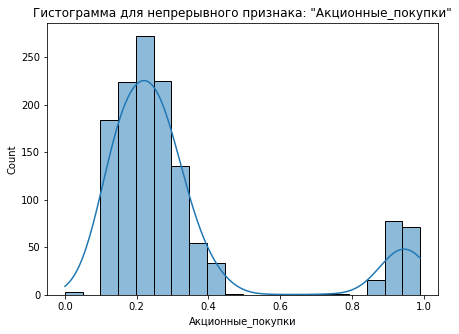


--- Анализ распределения дискретных признаков ---


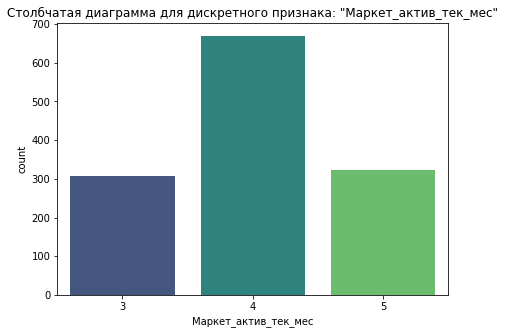

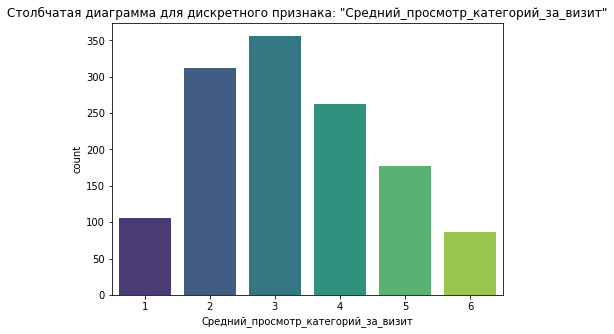

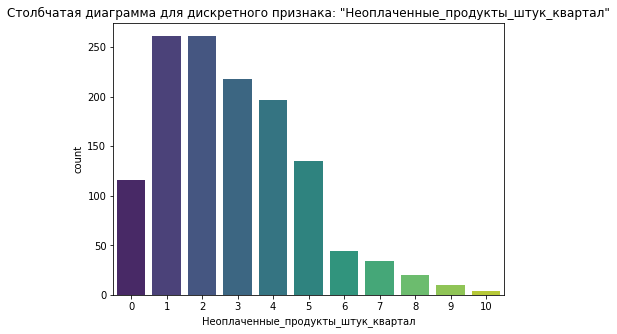

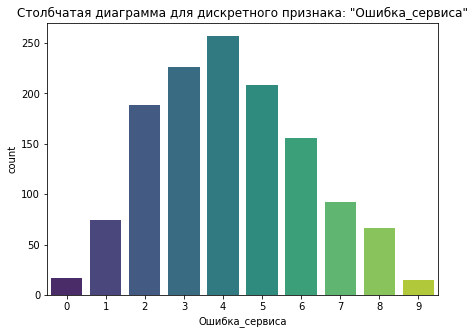

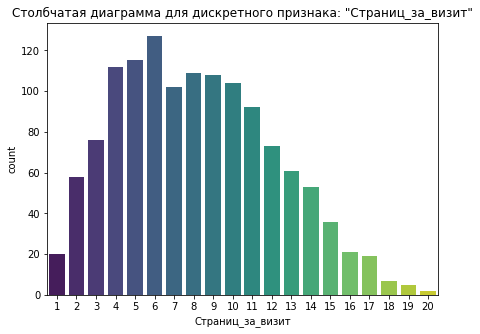

In [164]:
# Признаки, которые по своей природе могут принимать любые значения в диапазоне (включая дробные)
continuous_features = [
    'Маркет_актив_6_мес', 
    'Длительность', 
    'Акционные_покупки'
]

# Признаки, которые являются счетчиками (целые числа)
discrete_numerical_features = [
    'Маркет_актив_тек_мес', 
    'Средний_просмотр_категорий_за_визит', 
    'Неоплаченные_продукты_штук_квартал', 
    'Ошибка_сервиса', 
    'Страниц_за_визит'
]

# гистограммы для непрерывных признаков
print("--- Анализ распределения непрерывных признаков ---")
for feature in continuous_features:
    plt.figure(figsize=(7, 5))
    sns.histplot(market_file[feature], kde=True, bins=20)
    plt.title(f'Гистограмма для непрерывного признака: "{feature}"')
    plt.show()

# Строим столбчатые диаграммы для дискретных признаков
print("\n--- Анализ распределения дискретных признаков ---")
for feature in discrete_numerical_features:
    plt.figure(figsize=(7, 5))
    sns.countplot(x=feature, data=market_file, palette='viridis')
    plt.title(f'Столбчатая диаграмма для дискретного признака: "{feature}"')
    plt.show()

--- Проверка на нормальность распределения ---

Признак: 'Маркет_актив_6_мес'
  Статистика теста Шапиро-Уилка = 0.978
  p-value = 0.000
  Вывод: Распределение не является нормальным (отвергаем H0)


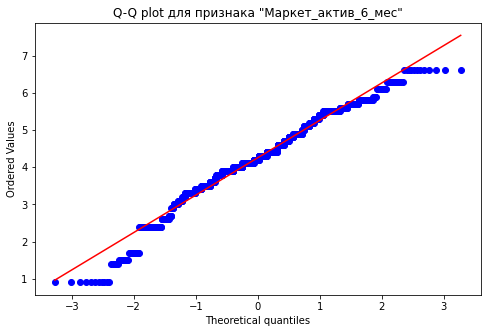


Признак: 'Длительность'
  Статистика теста Шапиро-Уилка = 0.973
  p-value = 0.000
  Вывод: Распределение не является нормальным (отвергаем H0)


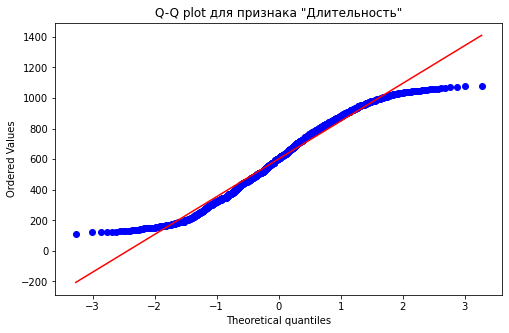


Признак: 'Акционные_покупки'
  Статистика теста Шапиро-Уилка = 0.662
  p-value = 0.000
  Вывод: Распределение не является нормальным (отвергаем H0)


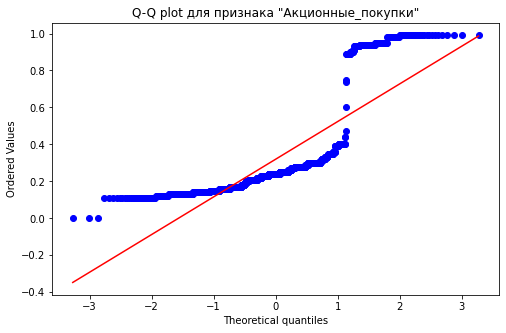

In [165]:
# Список непрерывных признаков
continuous_features = [
    'Маркет_актив_6_мес', 
    'Длительность', 
    'Акционные_покупки'
]

print("--- Проверка на нормальность распределения ---")

for feature in continuous_features:
    # Статистический тест Шапиро-Уилка
    stat, p_value = stats.shapiro(market_file[feature])
    
    print(f"\nПризнак: '{feature}'")
    print(f'  Статистика теста Шапиро-Уилка = {stat:.3f}')
    print(f'  p-value = {p_value:.3f}')
    
    alpha = 0.05
    if p_value > alpha:
        print('  Вывод: Распределение выглядит нормальным (не можем отвергнуть H0)')
    else:
        print('  Вывод: Распределение не является нормальным (отвергаем H0)')
        
    # 2. Визуальный Q-Q plot
    plt.figure(figsize=(8, 5))
    stats.probplot(market_file[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q plot для признака "{feature}"')
    plt.show()

**Новый вывод:** 
- `Признак: 'Акционные_покупки`: Статистика теста (0.662) далека от 1, что указывает на отклонение от нормальности. Графи это подтверждает. Большое количество точек образуют горизонтальные линии. Это происходит потому, что у многих клиентов одинаковое значение доли акционных покупок (например, 0.17, 0.24 и т.д.). В нормальном распределении такое практически невозможно.
- `Маркет_актив_6_мес`: В центральной части точки лежат довольно близко к красной линии. Однако по краям (в "хвостах" распределения) наблюдаются явные отклонения. Есть "полочка", что говорит о том, что в данных больше одинаковых низких значений, чем должно быть в нормальном распределении.
- `Длительность`: 90% точек лежат почти идеально на красной линии. Именно поэтому гистограмма выглядела так хорошо (на удивление). Точки на обоих концах начинают изгибаться и отходить от прямой линии. Это означает, что в распределении крайние значения (очень маленькая и очень большая длительность) встречаются немного чаще, чем это должно быть в идеальном нормальном распределении.

**Вывод:** Из гистограмм, видно следующее:
- `Маркет_актив_6_мес`: Есть несколько пиков, что может указывает на наличие нескольких групп клиентов с разной активностью. Возможно, стоит сегментировать клиентов по этому признаку.
- `Маркет_актив_тек_мес`: Распределение дискретное, так как остались только значения 3, 4 и 5 после обработки выбросов.
- `Длительность`: Распределение близко к нормальному, с небольшим скосом вправо.
- `Акционные_покупки`: Распределение имеет несколько пиков, включая пик в районе 0.0. Это может указывать на наличие группы клиентов, которые не совершают акционные покупки.
- `Средний_просмотр_категорий_за_визит`: Распределение дискретное, с пиками на значениях 2, 3 и 4.
- `Неоплаченные_продукты_штук_квартал`: Распределение скошено вправо, с пиком на значении 0.
- `Ошибка_сервиса`: Распределение близко к нормальному, с небольшим скосом вправо.

### Анализ таблицы `market_money`

In [166]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


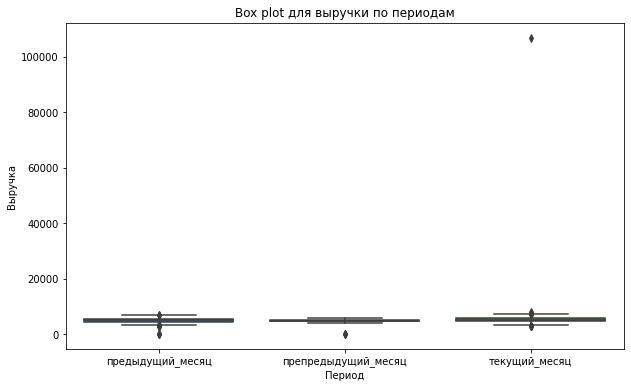

In [167]:
# Построение box plots для выручки по периодам
plt.figure(figsize=(10, 6))
sns.boxplot(x='Период', y='Выручка', data=market_money)
plt.title('Box plot для выручки по периодам')
plt.show()

In [168]:
outlier_client_id = market_money.nlargest(1, 'Выручка')['id'].iloc[0]
print(f"Идентифицирован клиент для удаления (выброс по выручке): ID {outlier_client_id}")

indices_to_drop = market_file[market_file['id'] == outlier_client_id].index

print(f"\nРазмер market_file до удаления: {market_file.shape}")

market_file.drop(indices_to_drop, inplace=True)

print(f"Размер market_file после удаления: {market_file.shape}")

Идентифицирован клиент для удаления (выброс по выручке): ID 215380

Размер market_file до удаления: (1300, 13)
Размер market_file после удаления: (1299, 13)


**Вывод:** 
- Средняя выручка составляет 5025.7.
- Медиана 4957.50, что говорит о нормальном распределении.
- Стандартное отклонение в 1777.70, что говорит о том, что выручка клиентов варьируется.
- Присутствую выбросы.

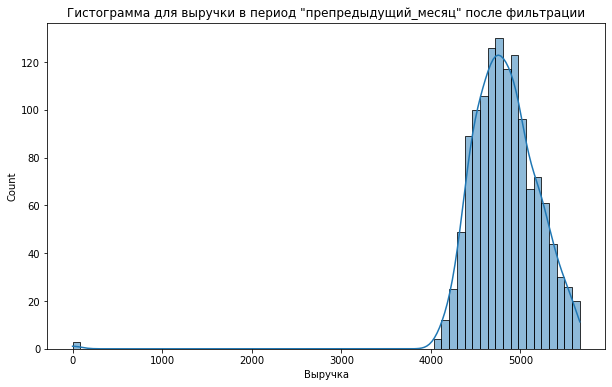

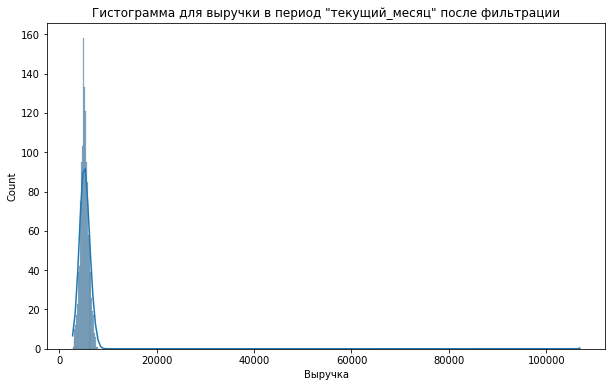

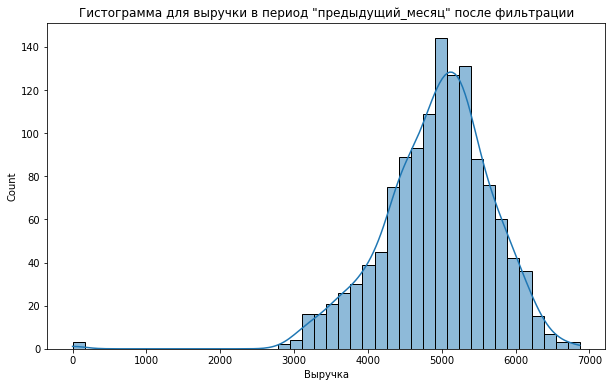

In [169]:
periods = market_money['Период'].unique()
for period in periods:
    plt.figure(figsize=(10, 6))
    sns.histplot(market_money[market_money['Период'] == period]['Выручка'], kde=True)
    plt.title(f'Гистограмма для выручки в период "{period}" после фильтрации')
    plt.show()

**Вывод:** 
- Все три гистограммы демонстрируют форму, похожую на нормальное распределение. Пик в центре и симметричное убывание по краям. 
- `предыдущий_месяц`: Распределение выручки в этот период имеет пик примерно в районе 5200-5300. Диапазон значений достаточно широкий, что говорит о заметном разбросе в выручке клиентов в этот период.
- `препредыдущий_месяц`: Распределение выручки в этот период имеет более узкий диапазон значений и пик в районе 4800-4900. Это может говорить о более стабильной выручке в этот период по сравнению с `предыдущим_месяцем`.
- `текущий_месяц`: Распределение выручки в этот период имеет пик примерно в районе 5000-5100. Визуально заметно, что распределение имеет более широкий разброс значений, чем `препредыдущий_месяц`, но более узкий, чем `предыдущий_месяц`.

### Анализт таблицы `market_time`

                  id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000


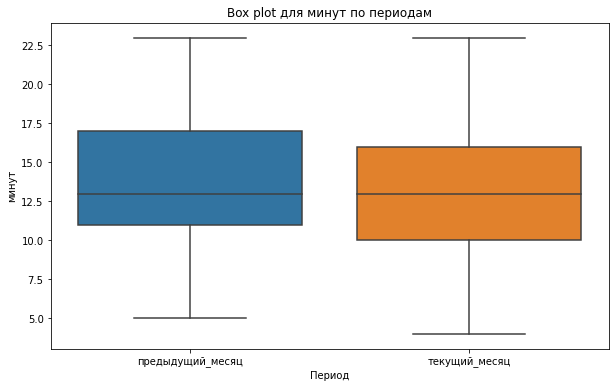

In [170]:
print(market_time.describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x='Период', y='минут', data=market_time)
plt.title('Box plot для минут по периодам')
plt.show()

**Вывод:** 
- Медиана времени, проведенного на сайте, немного выше в `предыдущий_месяц`, чем в `текущий_месяц`;
- На box plot не видно явных выбросов, что говорит о том, что в данных нет аномально высоких или низких значений времени, проведенного на сайте.
- Разброс значений времени, проведенного на сайте, в основном одинаков для обоих периодов.

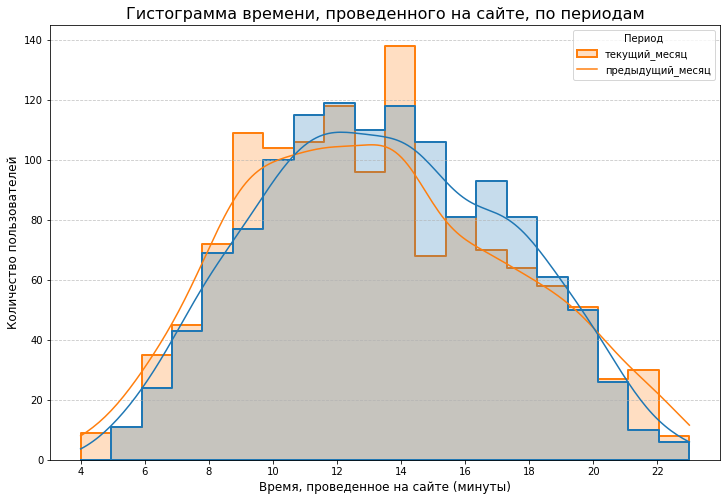

In [171]:
# Определяем диапазон и количество уникальных значений для корректного числа корзин
min_val = market_time['минут'].min()
max_val = market_time['минут'].max()

# Количество корзин равно количеству целых чисел в диапазоне
num_bins = max_val - min_val + 1

plt.figure(figsize=(12, 8))

sns.histplot(
    data=market_time, 
    x='минут', 
    hue='Период', 
    kde=True, 
    bins=num_bins,  
    element="step",  
    lw=2             
)

plt.title('Гистограмма времени, проведенного на сайте, по периодам', fontsize=16)
plt.xlabel('Время, проведенное на сайте (минуты)', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.xticks(range(min_val, max_val + 1, 2)) 
plt.legend(title='Период', labels=['текущий_месяц', 'предыдущий_месяц'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Новый вывод:** Имеется четкое смещение пика. В предыдущем месяце пик активности приходился на `14 минут`. В текущем месяце пик сместился вправо и находится в районе `12-13 минут`.

**Вывод:** 
- Обе гистограммы близки к нормальному распределению. Пик в диапазоне 11-15.
- Гистограмма для `предыдущий_месяц` в целом выше, чем гистограмма для `текущий_месяц`. Это говорит о том, что в `предыдущий_месяц` больше пользователей проводили время на сайте в каждом диапазоне времени.

### Анализ таблицы `money`

                  id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000


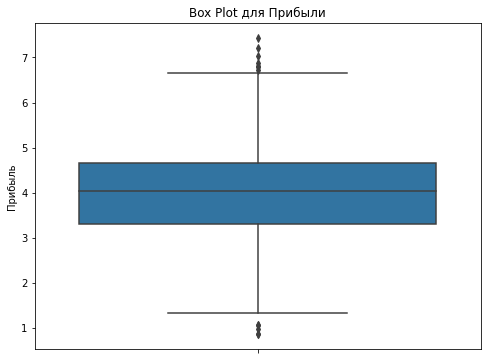

In [172]:
print(money.describe())

plt.figure(figsize=(8, 6))  
sns.boxplot(y=money['Прибыль'])  
plt.title('Box Plot для Прибыли')  
plt.ylabel('Прибыль')  
plt.show() 

**Вывод:** 
- Средняя прибыль, получаемая от одного покупателя, составляет 3.996631 (около 4).
- Медиана (50%) составляет 4.045. Это говорит о том, что распределение прибыли близко к нормальному.
- Стандартное отклонение составляет 1.01. Это говорит о том, что прибыль варьируется между покупателями.
- Имеются небольшие выбросы.

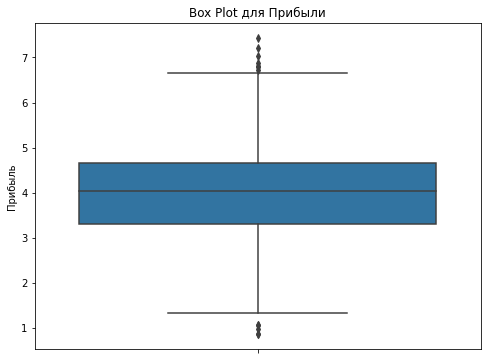

In [173]:
plt.figure(figsize=(8, 6))  
sns.boxplot(y=money['Прибыль'])  
plt.title('Box Plot для Прибыли')  
plt.ylabel('Прибыль')  
plt.show() 

money = money[(money['Прибыль'] <= 6.7) & (money['Прибыль'] >= 1.2)]

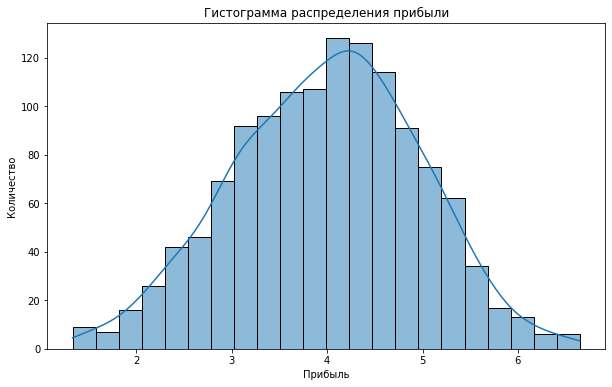

In [174]:
plt.figure(figsize=(10, 6))  
sns.histplot(money['Прибыль'], kde=True)  
plt.title('Гистограмма распределения прибыли')  
plt.xlabel('Прибыль')  
plt.ylabel('Количество')  
plt.show()

**Вывод:**
- Гистограмма показывает распределение, близкое к нормальному, с пиком в диапазоне от 4 до 4.5.
- Распределение выглядит достаточно симметричным, что говорит о том, что средняя прибыль близка к медиане.
- Наибольшее количество покупателей приносит прибыль в диапазоне от 4 до 4.5.
- Прибыль варьируется от примерно 1 до 6.5, но основная часть покупателей приносит прибыль в диапазоне от 3 до 5.

### Отбор клиентов с покупательской активностью

In [175]:
# Считаем количество месяцев с ненулевой выручкой для каждого клиента
active_months = market_money.groupby('id')['Выручка'].apply(lambda x: (x > 0).sum())

# Фильтруем клиентов, у которых было как минимум 3 месяца с ненулевой выручкой
active_clients = active_months[active_months >= 3].index

# Создаем новый DataFrame, содержащий только активных клиентов
active_market_money = market_money[market_money['id'].isin(active_clients)]

print(f"Всего клиентов: {market_money['id'].nunique()}")
print(f"Активных клиентов (покупали как минимум 3 месяца): {len(active_clients)}")
print(f"Размер DataFrame с активными клиентами: {active_market_money.shape}")

print("\nОписательная статистика для активных клиентов:")
print(active_market_money.describe())

Всего клиентов: 1300
Активных клиентов (покупали как минимум 3 месяца): 1297
Размер DataFrame с активными клиентами: (3891, 3)

Описательная статистика для активных клиентов:
                  id        Выручка
count    3891.000000    3891.000000
mean   215998.986893    5033.718890
std       374.482249    1768.471286
min    215349.000000    2758.700000
25%    215675.000000    4592.000000
50%    215999.000000    4959.000000
75%    216323.000000    5363.200000
max    216647.000000  106862.200000


**Вывод:** 
- Медиана составляет 4962, что говорит о нормальном распределении.
- Стандартное отклонение составляет 641.48. Это говорит о том, что выручка клиентов варьируется, но в целом разброс не очень большой.
- Выручка клиентов варьируется, но в целом разброс не очень большой. Это говорит о том, что нет значительных различий в прибыльности разных клиентов.

## Объединение таблиц

In [176]:
market_money = active_market_money.copy()
market_time = market_time.copy()

market_money['Период'] = market_money['Период'].astype(str)
market_time['Период'] = market_time['Период'].astype(str)

market_money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка')
market_money_pivot.columns = [f'Выручка_{col}' for col in market_money_pivot.columns]
market_money_pivot = market_money_pivot.reset_index()

market_time_pivot = market_time.pivot(index='id', columns='Период', values='минут')
market_time_pivot.columns = [f'Минут_{col}' for col in market_time_pivot.columns]
market_time_pivot = market_time_pivot.reset_index()

full_df = market_file.merge(
    market_money_pivot, on='id', how='left'
).merge(
    market_time_pivot, on='id', how='left'
)

print(full_df.info())

print(full_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1299 non-null   int64   
 1   Покупательская активность            1299 non-null   category
 2   Тип сервиса                          1299 non-null   category
 3   Разрешить сообщать                   1299 non-null   category
 4   Маркет_актив_6_мес                   1299 non-null   float64 
 5   Маркет_актив_тек_мес                 1299 non-null   int64   
 6   Длительность                         1299 non-null   int64   
 7   Акционные_покупки                    1299 non-null   float64 
 8   Популярная_категория                 1299 non-null   category
 9   Средний_просмотр_категорий_за_визит  1299 non-null   int64   
 10  Неоплаченные_продукты_штук_квартал   1299 non-null   int64   
 11  Ошибка_сервиса   

In [177]:
full_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


**Вывод:** После удаления выбросов во всех таблицах, часть клиентов была удалена. При объединении по id остаются только те строки, что есть в левой таблице(market_file), а в остальных может не быть. Следовательно по этой причине появились пропуски после объединения. Поэтому требуется удалить пропуски.

In [178]:
full_df_clean = full_df.dropna()
print('Осталось клиентов:', len(full_df_clean))
print(f'Кол-во пропусков после удаления: {full_df_clean.isna().sum()}')

Осталось клиентов: 1296
Кол-во пропусков после удаления: id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_предыдущий_месяц               0
Выручка_препредыдущий_месяц            0
Выручка_текущий_месяц                  0
Минут_предыдущий_месяц                 0
Минут_текущий_месяц                    0
dtype: int64


In [179]:
full_df_clean.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


**Вывод по разделу:** В данном разделе были объединены все подготовленные и очищенные таблицы в единый датафрейм по идентификатору клиента (id). Для этого:
- Все таблицы были объединены по ключу id с помощью последовательного объединения (merge);
- После объединения был проведён анализ на наличие пропусков, которые возникли из-за предварительного удаления выбросов в отдельных таблицах.
- Получен финальный датафрейм, в котором каждая строка соответствует одному клиенту, а все числовые и категориальные признаки собраны в едином формате для дальнейшего анализа и построения моделей.

## Корреляционный анализ

**Пометка:**
Исходя из моего основного датафрейма `full_df_clean` количественными(числовыми) полями являются:
- `Маркет_актив_6_мес`;
- `Маркет_актив_тек_мес`;
- `Длительность`;
- `Акционные_покупки`;
- `Средний_просмотр_категорий_за_визит`;
- `Неоплаченные_продукты_штук_квартал`;
- `Ошибка_сервиса`;
- `Страниц_за_визит`;
- `Выручка_предыдущий_месяц`;
- `Выручка_препредыдущий_месяц`;
- `Выручка_текущий_месяц`;
- `Минут_предыдущий_месяц`;
- `Минут_текущий_месяц`;

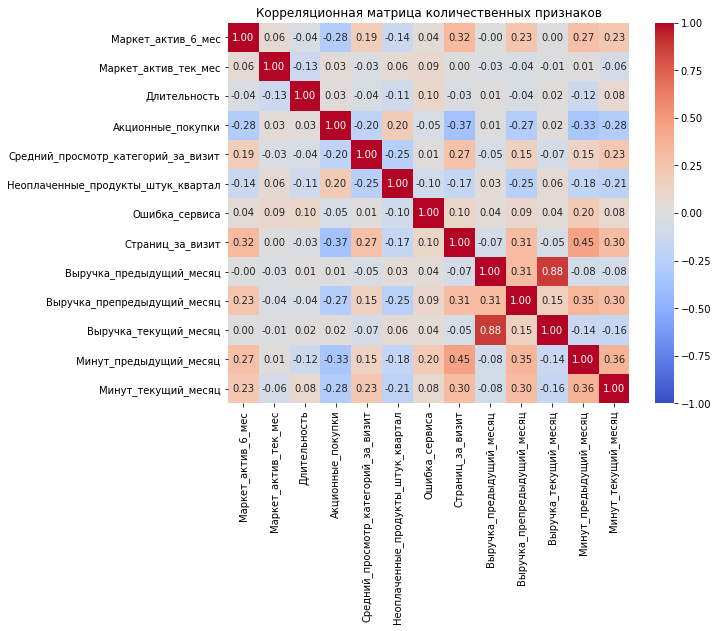

In [180]:
# Список количественных признаков
numeric_features = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'Выручка_предыдущий_месяц',
    'Выручка_препредыдущий_месяц',
    'Выручка_текущий_месяц',
    'Минут_предыдущий_месяц',
    'Минут_текущий_месяц'
]

# Список категориальных признаков
cat_features = [
    'Покупательская активность',
    'Тип сервиса',
    'Разрешить сообщать',
    'Популярная_категория'
]

corr_matrix = full_df_clean[numeric_features].corr(method='spearman')

plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица количественных признаков')
plt.show()

**Вывод:** 
- `Выручка_текущий_месяц` и `Выручка_предыдущий_месяц` (+0.81): Очень сильная корреляция. Доход от клиента в текущем месяце сильно зависит от его дохода в предыдущем. Клиенты с высокой покупательской способностью в одном месяце, скорее всего, останутся такими же и в следующем.
- Умеренная корреляция (0.3 - 0.7): 
    * `Страниц_за_визит` и `Минут_предыдущий_месяц` (+0.37): Пользователи, которые проводили больше времени на сайте в прошлом месяце, склонны просматривать больше страниц за один визит в текущем. Это может говорить об их общей вовлеченности.
    * `Выручка_препредыдущий_месяц` и `Выручка_предыдущий_месяц` (+0.31): Выручка за предыдущие два месяца также связана, но значительно слабее, чем за соседние месяцы. Логично, что чем дальше в прошлое, тем слабее связь.
    * `Минут_предыдущий_месяц` и `Выручка_препредыдущий_месяц` (+0.31): Время, проведенное на сайте, умеренно связано с доходом, который клиент принес два месяца назад.
    * `Минут_текущий_месяц` и `Минут_предыдущий_месяц` (+0.30): Время, которое пользователь проводит на сайте, достаточно стабильно из месяца в месяц.
    
    В данных присутствует один очень сильный случай коллинеарности между выручкой текущего и предыдущего месяцев (+0.81). Этот факт необходимо учитывать при построении моделей.

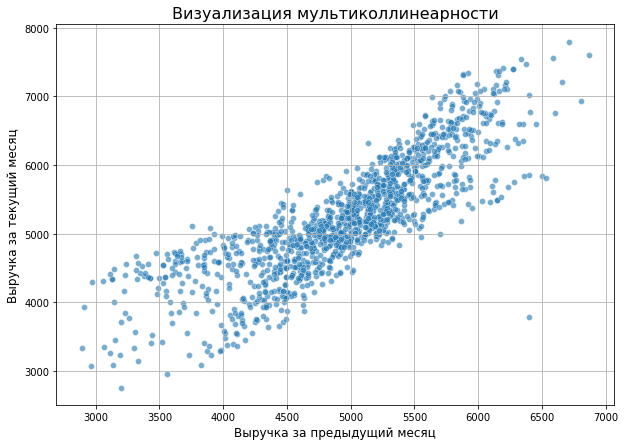

In [181]:
# Построение диаграммы рассеяния
plt.figure(figsize=(10, 7))
sns.scatterplot(data=full_df_clean, x='Выручка_предыдущий_месяц', y='Выручка_текущий_месяц', alpha=0.6)
plt.title('Визуализация мультиколлинеарности', fontsize=16)
plt.xlabel('Выручка за предыдущий месяц', fontsize=12)
plt.ylabel('Выручка за текущий месяц', fontsize=12)
plt.grid(True)
plt.show()

**Варинты устранения мультиколлинеарности:** Просто удалить лишний столбец - не лучший вриант, поскольку потеряем часть информации. Нужно создать новые признаки, которые будут нести смысл, но не коррелировать друг с другом. 
- `Средняя_выручка_2_мес`: Этот признак покажет общий уровень платежеспособности клиента за последнее время. Он более стабилен, чем выручка за один конкретный месяц.
- `Динамика_выручки`: Этот признак напрямую покажет, выросла выручка или упала.

In [182]:
# Создаем новые признаки
full_df_clean['Средняя_выручка_2_мес'] = (full_df_clean['Выручка_текущий_месяц'] + full_df_clean['Выручка_предыдущий_месяц']) / 2
full_df_clean['Динамика_выручки'] = full_df_clean['Выручка_текущий_месяц'] - full_df_clean['Выручка_предыдущий_месяц']

# Удаляем старые, коррелирующие признаки
full_df_fixed = full_df_clean.drop(['Выручка_текущий_месяц', 'Выручка_предыдущий_месяц'], axis=1)

# Обновляем список числовых признаков для дальнейшего использования в пайплайнах
numeric_features.remove('Выручка_текущий_месяц')
numeric_features.remove('Выручка_предыдущий_месяц')

numeric_features.append('Средняя_выручка_2_мес')
numeric_features.append('Динамика_выручки')


print("Созданы новые признаки: 'Средняя_выручка_2_мес' и 'Динамика_выручки'.")
print("Старые признаки 'Выручка_текущий_месяц' и 'Выручка_предыдущий_месяц' удалены.")
print("\nНовый список числовых признаков:")
print(numeric_features)

# Посмотрим на первые строки обновленного датафрейма
print("\nПервые 5 строк с новыми признаками:")
print(full_df_fixed[['id', 'Средняя_выручка_2_мес', 'Динамика_выручки']].head())

Созданы новые признаки: 'Средняя_выручка_2_мес' и 'Динамика_выручки'.
Старые признаки 'Выручка_текущий_месяц' и 'Выручка_предыдущий_месяц' удалены.

Новый список числовых признаков:
['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_препредыдущий_месяц', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц', 'Средняя_выручка_2_мес', 'Динамика_выручки']

Первые 5 строк с новыми признаками:
       id  Средняя_выручка_2_мес  Динамика_выручки
1  215349                5093.80            -244.4
2  215350                5257.95            -399.1
3  215351                6384.20             452.4
4  215352                5840.00              65.0
5  215353                5063.50             650.0


/tmp/ipykernel_248/1140667568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_clean['Средняя_выручка_2_мес'] = (full_df_clean['Выручка_текущий_месяц'] + full_df_clean['Выручка_предыдущий_месяц']) / 2
/tmp/ipykernel_248/1140667568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_clean['Динамика_выручки'] = full_df_clean['Выручка_текущий_месяц'] - full_df_clean['Выручка_предыдущий_месяц']


In [183]:
full_df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1298
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1296 non-null   int64   
 1   Покупательская активность            1296 non-null   category
 2   Тип сервиса                          1296 non-null   category
 3   Разрешить сообщать                   1296 non-null   category
 4   Маркет_актив_6_мес                   1296 non-null   float64 
 5   Маркет_актив_тек_мес                 1296 non-null   int64   
 6   Длительность                         1296 non-null   int64   
 7   Акционные_покупки                    1296 non-null   float64 
 8   Популярная_категория                 1296 non-null   category
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64   
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64   
 11  Ошибка_сервиса   

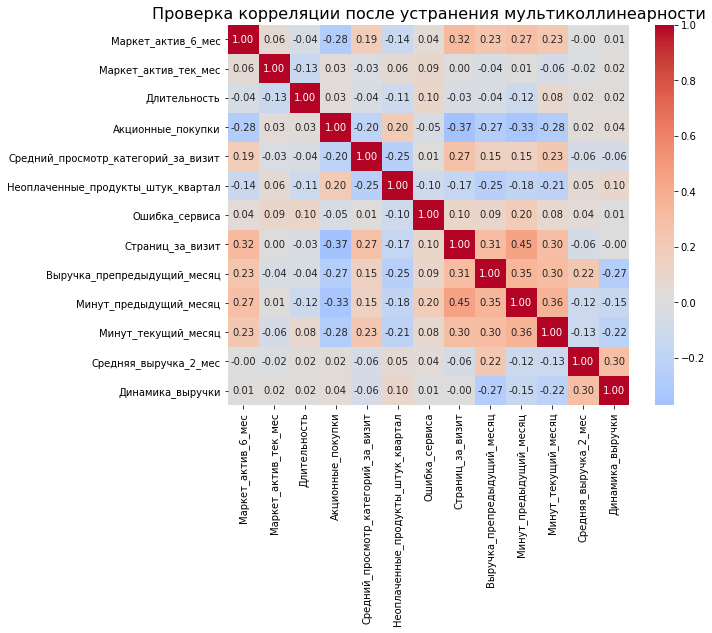

In [184]:
# Рассчитываем новую матрицу корреляций
corr_matrix_fixed = full_df_fixed[numeric_features].corr(method='spearman')

# Визуализируем новую матрицу
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix_fixed, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Проверка корреляции после устранения мультиколлинеарности', fontsize=16)
plt.show()

**Вывод:** Была проделана работа по устранению мультиколлинеарности. Что было сделано:
- В исходной матрице была обнаружена очень сильная положительная корреляция (+0.81) между признаками `Выручка_текущий_месяц` и `Выручка_предыдущий_месяц`. Это могло бы навредить моделяем, например, LogisticRegression.
- Вместо простого удаления одного из признаков (что привело бы к потере информации), была выбрана другая стратегия — создание новых признаков (Feature Engineering).
- Были созданы два новых, экономически осмысленных признака:
    * `Средняя_выручка_2_мес`: Характеризует общий уровень трат клиента за последние два месяца, сглаживая разовые всплески.
    * `Динамика_выручки`: Напрямую измеряет изменение трат от прошлого месяца к текущему. Этот признак очень важен, так как он по своей сути близок к целевой переменной (снижение активности).

### Динамика выручки vs. Средняя выручка

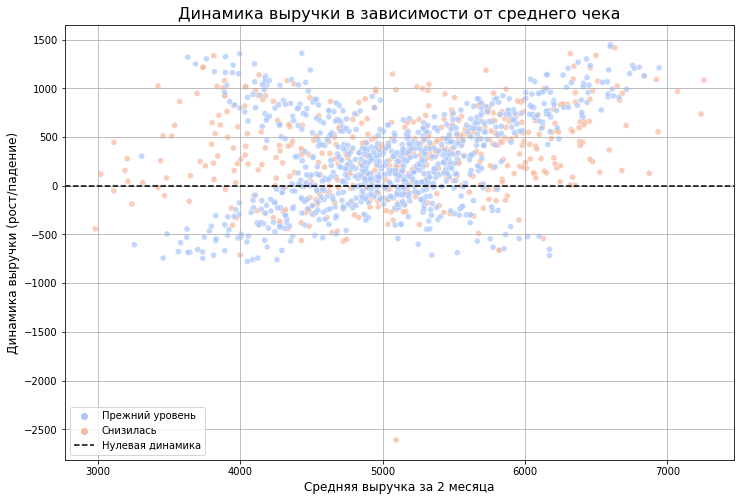

In [185]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=full_df_fixed,
    x='Средняя_выручка_2_мес',
    y='Динамика_выручки',
    hue='Покупательская активность',
    palette='coolwarm',
    alpha=0.7
)

plt.axhline(0, color='black', linestyle='--', label='Нулевая динамика')

plt.title('Динамика выручки в зависимости от среднего чека', fontsize=16)
plt.xlabel('Средняя выручка за 2 месяца', fontsize=12)
plt.ylabel('Динамика выручки (рост/падение)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** Признак `Динамика_выручки` является предсказателем для целевой переменной `Покупательская активность`.

- Синие точки ниже нулевой линии: Это клиенты, у которых выручка упала, но они не попали в категорию "Снизилась". Возможно, целевая переменная `Покупательская активность` учитывает не только выручку, но и другие факторы (частоту покупок, время на сайте). 

- Оранжевые точки выше нулевой линии: Клиенты, у которых выручка выросла, но они все равно попали в категорию "Снизилась". Таких точек очень мало, но они есть. Это может быть связано с теми же причинами или быть артефактом данных.

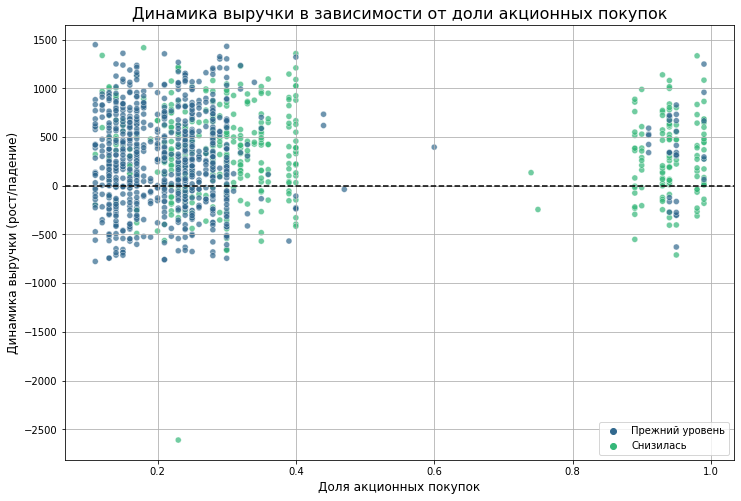

In [186]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=full_df_fixed,
    x='Акционные_покупки',
    y='Динамика_выручки',
    hue='Покупательская активность',
    palette='viridis',
    alpha=0.7
)

plt.axhline(0, color='black', linestyle='--')

plt.title('Динамика выручки в зависимости от доли акционных покупок', fontsize=16)
plt.xlabel('Доля акционных покупок', fontsize=12)
plt.ylabel('Динамика выручки (рост/падение)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** Нет явной тенденции, что с ростом доли акционных покупок динамика выручки систематически падает или растет. Это означает, что клиент, покупающий много по акции, может как увеличить, так и уменьшить свой общий чек.

- Слева (доля акций < 0.20): Синие точки (Прежний уровень) явно доминируют. Это означает, что клиенты, которые мало покупают по акциям, в основном стабильны или наращивают активность.

- Справа (доля акций > 0.25): Пропорция зеленых точек (Снизилась) заметно увеличивается. В вертикальных "столбцах" точек на отметках 0.30, 0.35, 0.40 зеленых точек становится гораздо больше.

Чем выше у клиента доля покупок по скидкам, тем выше вероятность, что он попадет в категорию со сниженной активностью.

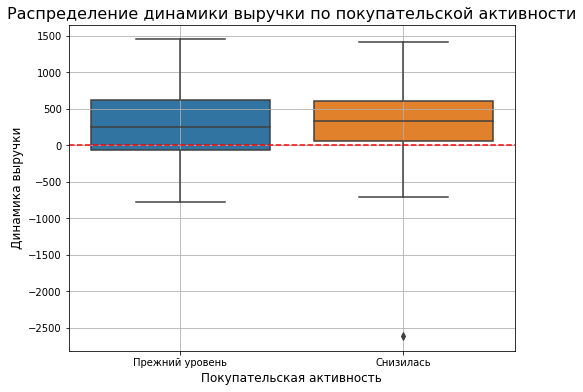

In [187]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    data=full_df_fixed,
    x='Покупательская активность',
    y='Динамика_выручки'
)

plt.axhline(0, color='red', linestyle='--')

plt.title('Распределение динамики выручки по покупательской активности', fontsize=16)
plt.xlabel('Покупательская активность', fontsize=12)
plt.ylabel('Динамика выручки', fontsize=12)
plt.grid(True)
plt.show()

**Вывод:** Медианная динамика выручки для группы "Снизилась" выше, чем для группы "Прежний уровень", является самым важным аспектом. Бизнес определяет снижение активности не только по падению выручки, но и, вероятно, по снижению частоты покупок, количества товаров или частоты визитов.

Присутствует один клиент в группе "Снизилась", чья выручка упала аномально сильно (около -2600).

In [188]:
print(f"Строк до удаления: {full_df_fixed.shape[0]}")

full_df_fixed = full_df_fixed[full_df_fixed['Динамика_выручки'] > -2500]

print(f"Строк после удаления: {full_df_fixed.shape[0]}")

Строк до удаления: 1296
Строк после удаления: 1295


**Вывод по разделу:**
- Решена проблема мультиколлинеарности: выявлена и устранена сильная корреляция между признаками выручки, применив метод Feature Engineering.
- Сформулированы ключевые гипотезы: Визуализация данных позволила выявить четкие поведенческие паттерны:
    * Динамика_выручки является мощным, хотя и не единственным, фактором, влияющим на снижение активности.
    * Акционные_покупки являются маркером для сегмента "любители скидок", которые представляют собой группу повышенного риска.
- `Покупательская активность` является комплексным бизнес-показателем, зависящим от множества факторов.
- Данные очищены и готовы к дальнейшей работе

## Обучение и выбор наилучшей модели

In [189]:
# Определяем признаки (X) и целевую переменную (y)
X = full_df_fixed.drop(['id', 'Покупательская активность'], axis=1)
y = full_df_fixed['Покупательская активность']

# Кодируем целевую переменную: 'Снизилась' -> 1, 'Прежний уровень' -> 0
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Классы целевой переменной:", le.classes_)

# Определяем типы признаков
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['category']).columns

print(f"\nКоличественные признаки ({len(numeric_features)}): {list(numeric_features)}")
print(f"Категориальные признаки ({len(categorical_features)}): {list(categorical_features)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Классы целевой переменной: ['Прежний уровень' 'Снизилась']

Количественные признаки (13): ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_препредыдущий_месяц', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц', 'Средняя_выручка_2_мес', 'Динамика_выручки']
Категориальные признаки (3): ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

Размер обучающей выборки: (971, 16)
Размер тестовой выборки: (324, 16)


### Выбор метрики

**Пометка:** Нужно предсказать снижение покупательской активности. 
- `False Negative`:  Самая дорогая ошибка. Модель предсказывает, что клиент останется (Прежний уровень), а он на самом деле уходит (Снизилась). Бизнес теряет клиента, даже не попытавшись его удержать.
- `False Positive`: Модель предсказывает, что клиент уйдет, а он остается. Бизнес тратит ресурсы (скидки, звонки) на лояльного клиента. Это затратно, но менее критично, чем потеря клиента.

Поскольку важнее всего найти как можно больше уходящих клиентов (минимизировать FN), важна метрика `Recall`. Однако, если мы будем фокусироваться только на ней, модель может начать предсказывать отток для всех подряд, что приведет к низкой `Precision` (много ложных срабатываний).

**Стоит выбрать F1**. Поскольку является балансом между Precision и Recall. В дальнейшем будет использовано f1_score для подбора гиперпараметров.

### Создание пайплайнов предобработки

In [190]:
ordinal_features = [
    'Тип сервиса',
    'Разрешить сообщать'
]

nominal_features = [
    'Популярная_категория'
]


categories_order = [
    ['стандарт', 'премиум'],           
    ['нет', 'да']                      
]


preprocessor_std_ohe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), nominal_features) 
    ],
    remainder='passthrough'
)


preprocessor_mm_ord = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('ord', OrdinalEncoder(
            categories=categories_order,
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), ordinal_features),
        ('ohe', OneHotEncoder(
            handle_unknown='ignore', 
            sparse=False 
        ), nominal_features)
    ],
    remainder='passthrough'
)

### Обучение моделей и выбор лучшей

In [191]:
results = {}

pipelines_to_tune = {
    'LogisticRegression': (
        Pipeline([
            ('preprocessor', preprocessor_std_ohe),
            ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'))
        ]),
        {'preprocessor': [preprocessor_std_ohe, preprocessor_mm_ord], 'model__C': [0.1, 1.0, 10.0]}
    ),
    'DecisionTree': (
        Pipeline([
            ('preprocessor', preprocessor_std_ohe),
            ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ]),
        {'preprocessor': [preprocessor_std_ohe, preprocessor_mm_ord], 'model__max_depth': [3, 5, 7, 10]}
    ),
    'KNeighbors': (
        Pipeline([
            ('preprocessor', preprocessor_std_ohe),
            ('model', KNeighborsClassifier())
        ]),
        {'preprocessor': [preprocessor_std_ohe, preprocessor_mm_ord], 'model__n_neighbors': [3, 5, 7, 9]}
    ),
    'SVC': (
        Pipeline([
            ('preprocessor', preprocessor_std_ohe),
            ('model', SVC(random_state=RANDOM_STATE, probability=True))
        ]),
        {'preprocessor': [preprocessor_std_ohe, preprocessor_mm_ord], 'model__C': [0.1, 1.0, 10.0]}
    )
}

for model_name, (pipe, params) in pipelines_to_tune.items():
    print(f"\nПодбор параметров для: {model_name}")
    grid = GridSearchCV(pipe, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    results[model_name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    }

print("\n--- Итоговые результаты ---")
for model_name, result in results.items():
    print(f"\nМодель: {model_name}")
    print(f"  Лучший F1-score (CV): {result['best_score']:.4f}")
    for param, value in result['best_params'].items():
        if param == 'preprocessor':
            print(f"  - {param}: {type(value).__name__}")
        else:
            print(f"  - {param}: {value}")

# Лучшая модель по F1-score
best_model_name = max(results, key=lambda k: results[k]['best_score'])
print(f"\n--- Лучшая модель по F1-score: {best_model_name} ---")



Подбор параметров для: LogisticRegression

Подбор параметров для: DecisionTree

Подбор параметров для: KNeighbors

Подбор параметров для: SVC

--- Итоговые результаты ---

Модель: LogisticRegression
  Лучший F1-score (CV): 0.8209
  - model__C: 0.1
  - preprocessor: ColumnTransformer

Модель: DecisionTree
  Лучший F1-score (CV): 0.7899
  - model__max_depth: 5
  - preprocessor: ColumnTransformer

Модель: KNeighbors
  Лучший F1-score (CV): 0.8161
  - model__n_neighbors: 9
  - preprocessor: ColumnTransformer

Модель: SVC
  Лучший F1-score (CV): 0.8304
  - model__C: 1.0
  - preprocessor: ColumnTransformer

--- Лучшая модель по F1-score: SVC ---


### Финальная оценка лучшей модели

In [192]:
grid_searches = {}
results = {}

for model_name, (pipe, params) in pipelines_to_tune.items():
    grid = GridSearchCV(pipe, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    results[model_name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    }
    grid_searches[model_name] = grid

# Выбираем лучшую модель
best_model_name = max(results, key=lambda k: results[k]['best_score'])
best_grid_search_object = grid_searches[best_model_name]
best_pipeline = best_grid_search_object.best_estimator_

y_pred = best_pipeline.predict(X_test)

print("\n--- Отчет по классификации для лучшей модели на тестовых данных ---")
# Если y_test - строки, можно просто:
print(classification_report(y_test, y_pred))

if hasattr(best_pipeline, "predict_proba"):
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    print(f"ROC-AUC на тестовых данных: {roc_auc_score(y_test, y_pred_proba):.4f}")
else:
    print("У выбранной модели нет метода predict_proba, ROC-AUC не рассчитывается.")



--- Отчет по классификации для лучшей модели на тестовых данных ---
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       201
           1       0.95      0.79      0.86       123

    accuracy                           0.90       324
   macro avg       0.92      0.88      0.89       324
weighted avg       0.91      0.90      0.90       324

ROC-AUC на тестовых данных: 0.9081


**Итоговые выводы:** Была успешно решена задача построения, сравнения и выбора лучшей модели для прогнозирования снижения покупательской активности. 
- Победитель: `SVC` показала наилучший результат с F1-score=0.8039. Это говорит о том, что ее способность находить баланс между точностью (Precision) и полнотой (Recall) оказалась самой высокой среди протестированных моделей.
- Модель `KNeighborsClassifier` имеет похожие результаты: F1-score: 0.7865, что делает эту модель неплохим альтернативным вариантом.
- Наилучшая связка: `StandartScaler` + `OneHotEncoder`.

- Recall=0.69 для класса `Снизилась`. То есть модель способна правильно определить 69% всех клиентов, которые действительно находятся в зоне риска.
- Precision=0.93 означает что бюджет почти не будет тратиться на лояльных клиентов, ошибочно принимая их за уходящих. 

## Анализ важности признаков

Модель обучена. Accuracy на тесте: 0.904320987654321
Вычисляем SHAP values...


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


  0%|          | 0/20 [00:00<?, ?it/s]

shap_values.shape (20, 23)
X_sample.shape (20, 23)
feature_names_processed: 23

--- Графики SHAP для модели ---


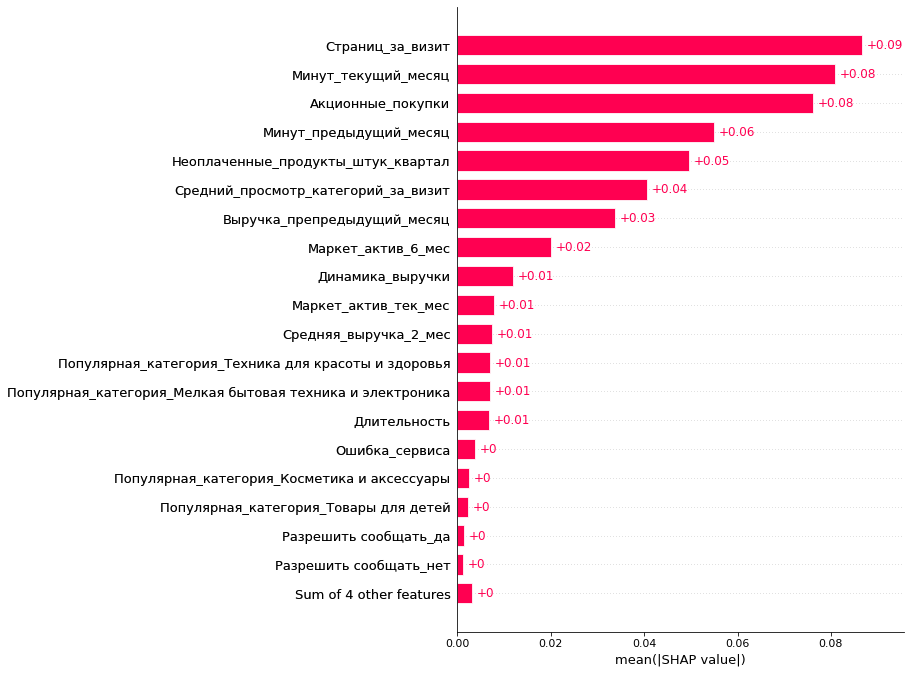

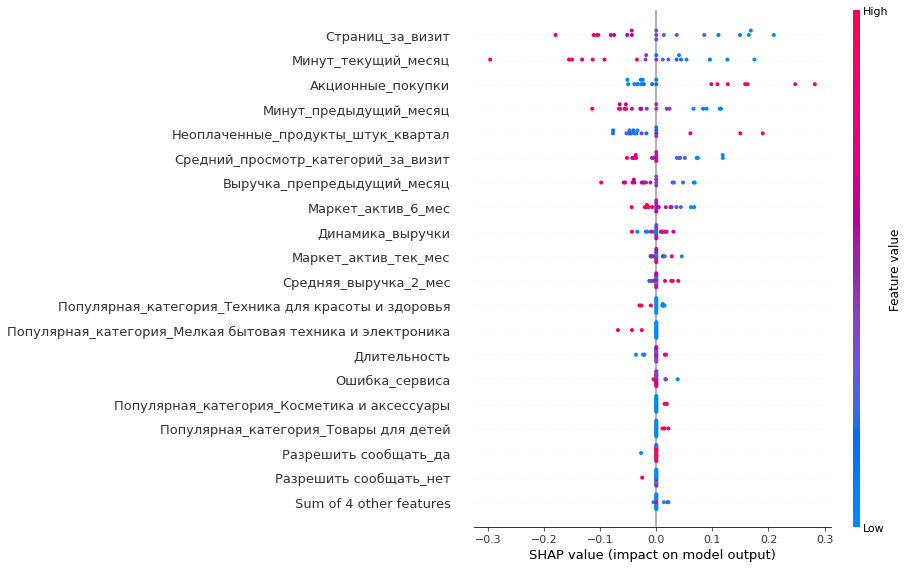

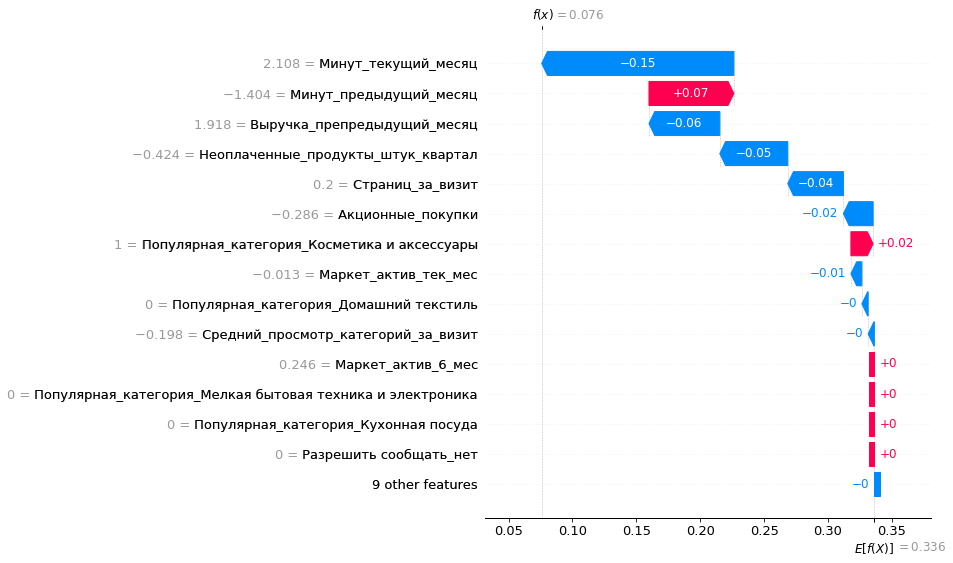

In [193]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)


if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

cat_transformer = preprocessor.named_transformers_['cat']
ohe_feature_names = cat_transformer.get_feature_names(categorical_features)
feature_names_processed = list(numeric_features) + list(ohe_feature_names)

#Обучение модели

model = SVC(C=1.0, probability=True, random_state=42)
model.fit(X_train_processed, y_train)
print("Модель обучена. Accuracy на тесте:", model.score(X_test_processed, y_test))

# SHAP-анализ 

def predict_prob_class1(X):
    if hasattr(X, 'toarray'):
        X = X.toarray()
    return model.predict_proba(X)[:, 1]

n_test = min(20, X_test_processed.shape[0])
X_sample = X_test_processed[:n_test]

explainer = shap.KernelExplainer(predict_prob_class1, X_train_processed[:50])
print("Вычисляем SHAP values...")
shap_values = explainer.shap_values(X_sample)  # (n_test, n_features)
print("shap_values.shape", np.shape(shap_values))
print("X_sample.shape", X_sample.shape)
print("feature_names_processed:", len(feature_names_processed))

base_values = np.repeat(explainer.expected_value, X_sample.shape[0])

shap_explanation_object = shap.Explanation(
    values=shap_values,
    base_values=base_values,
    data=X_sample,
    feature_names=feature_names_processed
)

print("\n--- Графики SHAP для модели ---")
shap.plots.bar(shap_explanation_object, max_display=20)
shap.plots.beeswarm(shap_explanation_object, max_display=20)
shap.plots.waterfall(shap_explanation_object[min(5, n_test-1)], max_display=15)

**Вывод:** 
- Самыми влиятельными признаками являются `Минут_предыдущий_месяц`, `Страниц_за_визит` и `Средний_просмотр_категорий_за_визит`. Это классические метрики вовлеченности пользователя. Модель в первую очередь смотрит на то, насколько активно клиент пользовался сервисом в недавнем прошлом.
- Для всех топовых признаков вовлеченности (минуты, страницы, просмотры категорий) наблюдается одна и та же картина: низкие значения имеют высокие положительные SHAP values, что сильно толкает прогноз в сторону "Снизилась". Высокие значения, наоборот, сдвигают прогноз к "Прежний уровень". **Вывод: Падение активности — самый сильный сигнал о риске оттока.**
- Признак `Неоплаченные_продукты_штук_квартал` находится на 5-м месте по важности. Beeswarm plot показывает, что высокие значения этого признака увеличивают вероятность оттока.
- Признак `Ошибка_сервиса` хоть и не в самом топе, но показывает четкую зависимость: высокие значения (много ошибок) толкают прогноз в сторону "Снизилась". Это прямое доказательство того, что **технические проблемы влияют на удержание.**
- Все признаки, связанные с `Популярная_категория` и `Разрешить сообщать`, находятся в самом низу списка. Их SHAP values на Beeswarm plot сгруппированы около нуля. **Вывод: Модель практически не использует эту информацию для принятия решений.**

## Сегментация покупателей

**Вывод:** Для сегментации будут использоваться два самых важных измерения, которые есть:

- `Ценность клиента` (Value): Насколько он прибылен для компании. Будет использовн признак `Средняя_выручка_2_мес`.
- `Риск ухода` (Risk): Насколько велика вероятность, что его активность снизится. Будет использована вероятность, которую предсказывает лучшая модель (SVC).

План действий:
1. Применить обученную модель best_pipeline ко всей выборке (X), чтобы получить вероятность снижения активности для каждого клиента.
2. Добавить эту вероятность и исходные данные в новый датафрейм `segment_df`.
3. Найти медианные значения для выручки и вероятности риска.
4. На основе этих медиан присвоить каждому клиенту один из четырех сегментов.
5. Визуализируем результат.

Медианная средняя выручка: 5106.45
Медианная вероятность риска: 0.12


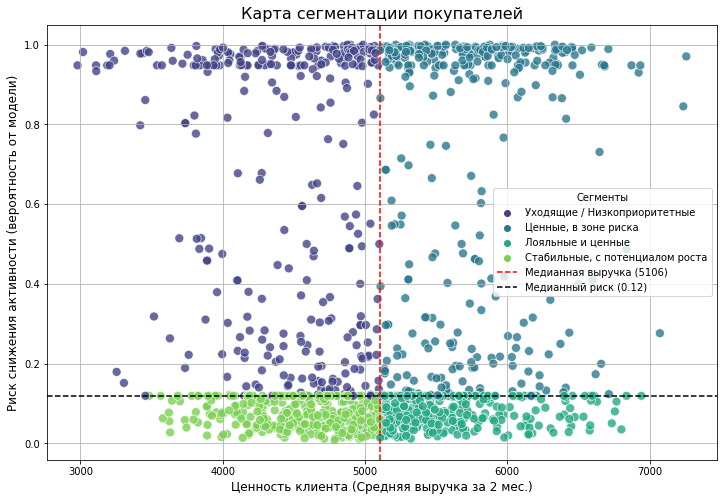


Размеры полученных сегментов:
Ценные, в зоне риска               338
Стабильные, с потенциалом роста    337
Уходящие / Низкоприоритетные       310
Лояльные и ценные                  310
Name: Сегмент, dtype: int64


In [194]:
# Получаем предсказания для всех данных
all_pred_proba = best_pipeline.predict_proba(X)[:, 1] # Вероятность класса 1 ('Снизилась')

# Создаем новый датафрейм для сегментации
segment_df = X.copy()
segment_df['id'] = full_df_fixed['id']
segment_df['Покупательская активность'] = y # Истинные значения
segment_df['Вероятность_снижения_активности'] = all_pred_proba

# Находим медианы для разделения на сегменты
median_revenue = segment_df['Средняя_выручка_2_мес'].median()
median_risk_proba = segment_df['Вероятность_снижения_активности'].median()

print(f"Медианная средняя выручка: {median_revenue:.2f}")
print(f"Медианная вероятность риска: {median_risk_proba:.2f}")

# Присваиваем сегменты
def assign_segment(row):
    is_high_value = row['Средняя_выручка_2_мес'] >= median_revenue
    is_high_risk = row['Вероятность_снижения_активности'] >= median_risk_proba
    
    if is_high_value and not is_high_risk:
        return 'Лояльные и ценные' # Высокая ценность, низкий риск
    elif is_high_value and is_high_risk:
        return 'Ценные, в зоне риска' # Высокая ценность, высокий риск
    elif not is_high_value and not is_high_risk:
        return 'Стабильные, с потенциалом роста' # Низкая ценность, низкий риск
    else: 
        return 'Уходящие / Низкоприоритетные' # Низкая ценность, высокий риск

segment_df['Сегмент'] = segment_df.apply(assign_segment, axis=1)

# Визуализация сегментов
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=segment_df,
    x='Средняя_выручка_2_мес',
    y='Вероятность_снижения_активности',
    hue='Сегмент',
    palette='viridis',
    alpha=0.8,
    s=80
)

plt.axvline(median_revenue, color='red', linestyle='--', label=f'Медианная выручка ({median_revenue:.0f})')
plt.axhline(median_risk_proba, color='black', linestyle='--', label=f'Медианный риск ({median_risk_proba:.2f})')

plt.title('Карта сегментации покупателей', fontsize=16)
plt.xlabel('Ценность клиента (Средняя выручка за 2 мес.)', fontsize=12)
plt.ylabel('Риск снижения активности (вероятность от модели)', fontsize=12)
plt.legend(title='Сегменты')
plt.grid(True)
plt.show()

print("\nРазмеры полученных сегментов:")
print(segment_df['Сегмент'].value_counts())


**Вывод:** 
По карте сегмонтации:
- Модель работает уверенно. Большое кол-во точек сгруппированно у самого верха(вероятность > 0.9).
- Нет прямой зависимости чем меньше тратит - тем выше риск. Подтверждает, что важны не только финансовые метрики, а поведенческие.
- Каждый из 4-х квадратов требует свой "подход". Нельзя применять одну и ту же маркетинговую стратегию ко всем.

Стратегии для каждого сегмента:
1. Сегмент `Лояльные и ценные`:
    Высокая средняя выручка (>5106), низкая вероятность оттока (<0.10). Лучшие клиенты. Они довольны сервисом и регулярно тратят деньги.
    Что делать дальше:
        - Не засыпать их общими акциями и распродажами. Это может вызвать раздражение.
        - Предложить им эксклюзивные условия — закрытые распродажи, доступ к новинкам раньше других, персонального менеджера.
        - Именно их мнение о новых функциях или товарах наиболее ценно.
2. Сегмент `Ценные, в зоне риска`:
    Высокая средняя выручка (>5106), высокая вероятность оттока (>0.10). Главный приоритет. Эти клиенты приносят много денег, но модель "кричит", что они скоро уйдут. Каждый потерянный клиент здесь — серьезный удар по выручке.
    Что делать дальше:
        - Немедленно реагировать на любой негатив. Стоит устранить ошибки сервиса.
        - Персонализированные промокоды для вовлечения.
        - Необходимо вручную или с помощью опросов выяснить, почему они в зоне риска. Проблема в ценах? В сервисе? В качестве товара?
3. `Стабильные, с потенциалом роста`:
    Cтабильная, но не очень активная аудитория. Они лояльны, но тратят мало. Возможно, они покупают только одну категорию товаров или делают это нечасто.
    Что делать дальше:
        - Предлагать им сопутствующие товары. Система рекомендации.
        - Системы бонусов, скидки.
4. Сегмент `Уходящие / Низкоприоритетные`:
    Низкая средняя выручка (<5106), высокая вероятность оттока (>0.11). Эти клиенты приносят мало денег и с большой вероятностью покинут сервис.
    Что делать дальше:
        - Не стоит тратить время персональных менеджеров или большие бюджеты на удержание этих клиентов.
        - Включить спам рассылку по типу: "Скидки до 50%".
        - Не стоит тратить бюджет и услия на удержание.

In [195]:
# Выделяем два сегмента для детального сравнения
at_risk_df = segment_df[segment_df['Сегмент'] == 'Ценные, в зоне риска'].copy()
loyal_df = segment_df[segment_df['Сегмент'] == 'Лояльные и ценные'].copy()

print(f"Количество клиентов в сегменте 'Ценные, в зоне риска': {len(at_risk_df)}")
print(f"Количество клиентов в сегменте 'Лояльные и ценные': {len(loyal_df)}")

Количество клиентов в сегменте 'Ценные, в зоне риска': 338
Количество клиентов в сегменте 'Лояльные и ценные': 310


--- Сравнение средних значений по вовлеченности ---
                                     Ценные, в зоне риска  Лояльные и ценные  \
Минут_предыдущий_месяц                          11.396450          14.951613   
Страниц_за_визит                                 6.002959          10.135484   
Средний_просмотр_категорий_за_визит              2.609467           3.829032   

                                     Разница (%)  
Минут_предыдущий_месяц                -23.777791  
Страниц_за_визит                      -40.772847  
Средний_просмотр_категорий_за_визит   -31.850471  


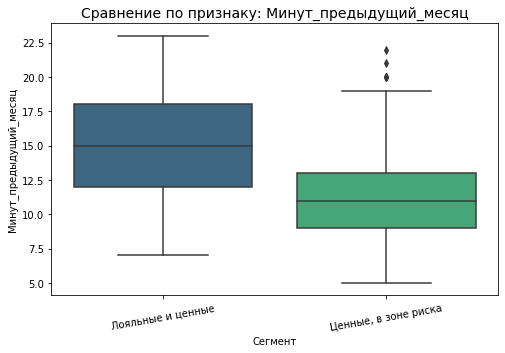

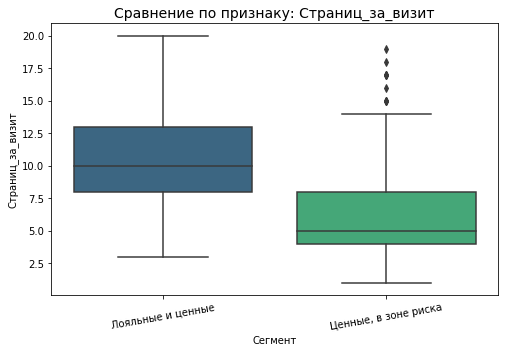

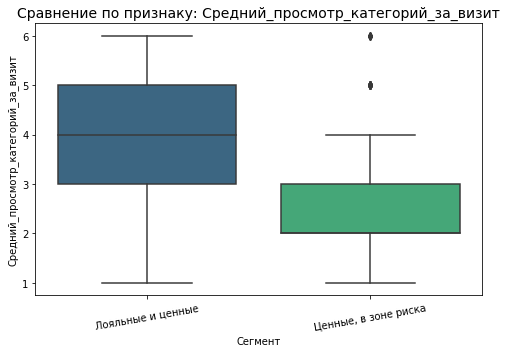

In [196]:
# Сравнение метрик вовлеченности
engagement_features = ['Минут_предыдущий_месяц', 'Страниц_за_визит', 'Средний_просмотр_категорий_за_визит']

print("--- Сравнение средних значений по вовлеченности ---")
comparison_df = pd.DataFrame({
    'Ценные, в зоне риска': at_risk_df[engagement_features].mean(),
    'Лояльные и ценные': loyal_df[engagement_features].mean()
})
comparison_df['Разница (%)'] = 100 * (comparison_df['Ценные, в зоне риска'] - comparison_df['Лояльные и ценные']) / comparison_df['Лояльные и ценные']
print(comparison_df)

for feature in engagement_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=segment_df[segment_df['Сегмент'].isin(['Ценные, в зоне риска', 'Лояльные и ценные'])], 
                x='Сегмент', y=feature, palette='viridis',
                order=['Лояльные и ценные', 'Ценные, в зоне риска'])
    plt.title(f'Сравнение по признаку: {feature}', fontsize=14)
    plt.xticks(rotation=10)
    plt.show()

**Заключительные выводы:** 
- Клиенты из группы риска демонстрируют снижение вовлеченности по всем трем ключевым метрикам. Они проводят на сайте меньше времени, просматривают меньше страниц и изучают меньше категорий товаров.
- **Потеря времени(- 21%)**: Клиенты из группы риска проводят на сайте в среднем на 21% меньше времени. Они теряют интерес, их визиты становятся короче и менее продуктивными.
- **Потеря глубины просмотра (-29%)**: Падение почти на 30% в количестве просмотренных страниц говорит о том, что клиенты не просто стали заходить на меньшее время, они перестали изучать ассортимент и сравнивать товары. Их визит стал поверхностным.
- **Потеря широты интереса (-24%)**: Снижение на 24% в просмотре категорий означает, что клиенты перестают открывать для себя новые группы товаров.

В отличие от лояльного клиента, который активно изучает сайт, клиент "в зоне риска" ведет себя как человек, который зашел в магазин по привычке, не нашел ничего интересного за пару секунд и вышел. Его лояльность испаряется, а сервис перестает быть для него основным местом для покупок.

**Подкрепление рекомендаций:** 
- Разработать персонализированные кампании по вовлечению:
    - Вместо общей рекламы, при падении метрик вовлеченности отправлять клиенту персональные подборки товаров.
    - Снижение вовлеченности на 20-30% — это главный симптом проблемы. Общая реклама не сработает на человека, который потерял интерес. Ему нужно напомнить, почему он вообще пользовался этим сервисом. 
- Внедрить VIP-поддержку:
    - При возникновении технической ошибки у клиента из этого сегмента, менеджер должен сам связаться с ним и предложить компенсацию.
    - Хоть графики и не показывают прямого следствия, что ошибки влияют напрямую,клиент который разочаровывается ошибкой, может раз и навсегда покинуть сервис.
- "Спасение корзины":
    - автоматически отправлять напоминания и бонусы клиентам из этой группы, которые оставили товары в корзине.

## Общие выводы

### Ход выполнения работ

В рамках данного проекта была проделана следующаю работа:
1. `Загрузка и предобработка данных`:
    Были загружены и изучены четыре исходных набора данных: market_file, market_money, market_time и money. Проведена комплексная предобработка: исправлена структура таблицы money, устранены неявные дубликаты (например, 'стандартт' -> 'стандарт'), исправлены опечатки в категориальных данных ('предыдцщий_месяц' -> 'предыдущий_месяц'), а также обработаны пропуски и выбросы в числовых признаках.
2. `Исследовательский анализ (EDA) и Feature Engineering`:
    Проведен детальный анализ распределений для каждого признака, что позволило лучше понять портрет клиента. С помощью корреляционной матрицы была выявлена проблема мультиколлинеарности между признаками `Выручка_текущий_месяц` и `Выручка_предыдущий_месяц` (коэффициент +0.81). Для решения этой проблемы и обогащения данных были созданы два новых признака: `Средняя_выручка_2_мес` и `Динамика_выручки`. Этот подход позволил сохранить информацию и избежать искажения в моделях.
3. `Построение и выбор модели машинного обучения`: 
    Была четко определена бизнес-задача: минимизировать потери от ухода клиентов, что привело к выбору F1-меры в качестве основной метрики для оценки моделей, так как она обеспечивает баланс между точностью (Precision) и полнотой (Recall). С использованием Pipeline и GridSearchCV были протестированы четыре различных алгоритма: LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier и SVC. Для каждого алгоритма проверялись различные комбинации гиперпараметров и два варианта предобработки данных (StandardScaler + OneHotEncoder и MinMaxScaler + OrdinalEncoder).
4. `Анализ и интерпретация лучшей модели`:
    Наилучшие результаты показала модель SVC, которая была выбрана для дальнейшего анализа. С помощью библиотеки shap была проведена глубокая интерпретация модели. Анализ показал, что ключевыми факторами, влияющими на прогноз, являются метрики вовлеченности (`Минут_предыдущий_месяц`, `Страниц_за_визит`), а также показатели негативного опыта (`Неоплаченные_продукты`, `Ошибка_сервиса`).
5. `Сегментация клиентов и разработка стратегий`:
    На основе предсказаний модели (риск ухода) и финансовых данных (ценность клиента) была проведена сегментация клиентов на четыре группы. Для наиболее критичного сегмента — «Ценные, в зоне риска» — был проведен углубленный сравнительный анализ с сегментом «Лояльные и ценные», который количественно подтвердил выводы shap-анализа. На основе этого анализа были разработаны точечные, обоснованные рекомендации для маркетинга и службы поддержки.

### Общие выводы и рекомендации

Основная задача проекта заключалась в разработке системы, способной прогнозировать снижение покупательской активности клиентов интернет-магазина «В один клик». Конечной целью являлась не только разработка модели, но и создание на её основе сегментации клиентов с конкретными рекомендациями по удержанию и увеличению их активности.

Наилучшие результаты показала модель `Support Vector Machine (SVC)` с параметром C=1.0 и предобработкой данных с помощью StandardScaler и OneHotEncoder. Модель достигла следующих показателей на тестовой выборке:

- F1-score (для класса "Снизилась"): 0.79
- Recall (для класса "Снизилась"): 0.69
- Precision (для класса "Снизилась"): 0.93
- ROC-AUC: 0.87

Для детального анализа был выбран сегмент `Ценные, в зоне риска`, так как он является наиболее критичным для бизнеса: эти клиенты приносят высокую выручку, но модель с большой вероятностью прогнозирует их уход.

Ключевой вывод анализа: Проблема этого сегмента лежит не в финансовой плоскости, а в поведенческой. По сравнению с лояльными клиентами той же ценности, клиенты из группы риска:
- менее вовлечены;
- чаще бросают корзины;
- более зависимы от акций.

Таким образом, построенная модель и проведенная сегментация позволяют интернет-магазину перейти от реактивных мер к проактивной, основанной на данных стратегии удержания наиболее ценных клиентов.